In [21]:
import pandas as pd
import plotly.express as px
from matplotlib import pyplot as plt

In [22]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Specifying location of the data
import os
os.chdir("/content/drive/MyDrive/Leaf_Wetness_Prediction_data")

In [24]:
numbers_of_stations=[1.0,2.0,3.0,9.0,13.0,14.0,15.0,28.0,29.0,30.0]
df = pd.DataFrame()
for station_number in numbers_of_stations:
  df_temp = pd.read_csv(f'station{station_number}_data.csv')
  df_temp['seriesdata_timestamp'] = pd.to_datetime(df_temp['seriesdata_timestamp'])
  df_temp = df_temp.set_index(['datasource_id','seriesdata_timestamp'], drop=True)
  df = pd.concat([df,df_temp], ignore_index=False)

In [25]:
def plot_variable(df, variable):
  df = df[[variable]]
  fig = px.scatter(df, x=df.index, y=variable)
  fig.show()

In [26]:
grouped = df.groupby('datasource_id')
for name, group in grouped:
  group = group.reset_index('datasource_id', drop=True)
  plot_variable(group, 'leaf_wetness')

There are two types of stations, ones record exact value of leaf wetness time and other only record "yes or no", they have eather maximum or minimum value of leaf wetness time.
I think that leaf wtness was actually measured only on this stations (1, 2, 3, 5, 6, 7). For other stations it was calculated by formula with outcome only "wet" or "dry"

In [27]:
df = df.drop([9.0,28.0,29.0,30.0],axis=0)

In [28]:
!pip install umap-learn

In [29]:
import umap

In [30]:
grouped = df.groupby('datasource_id')

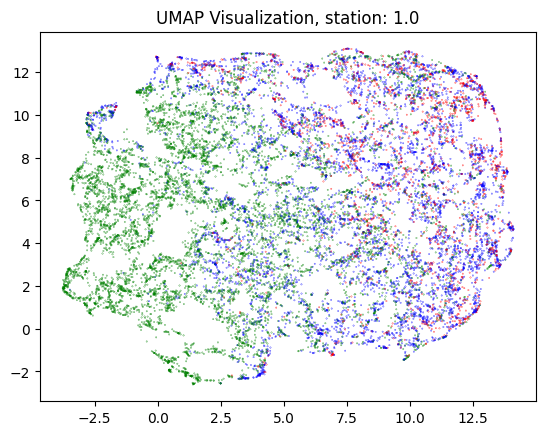

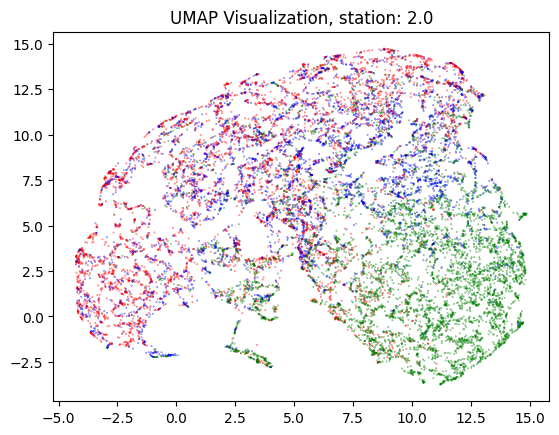

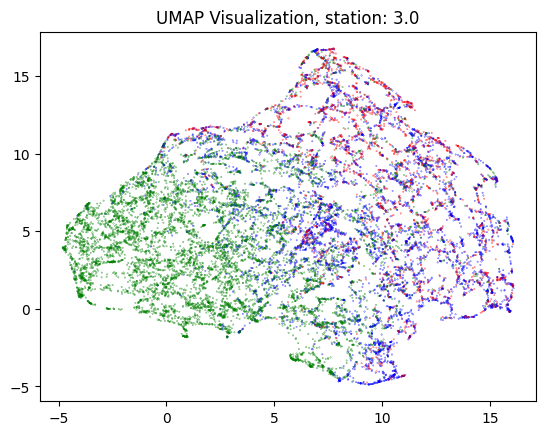

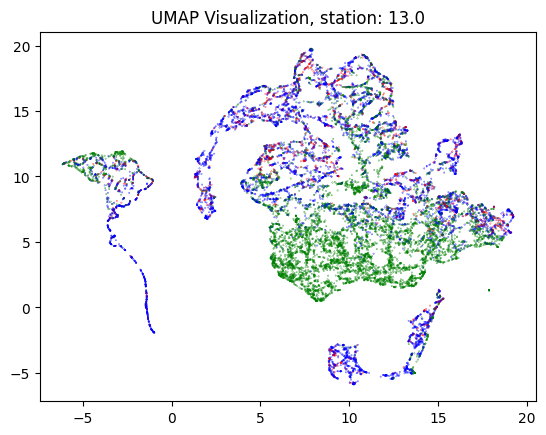

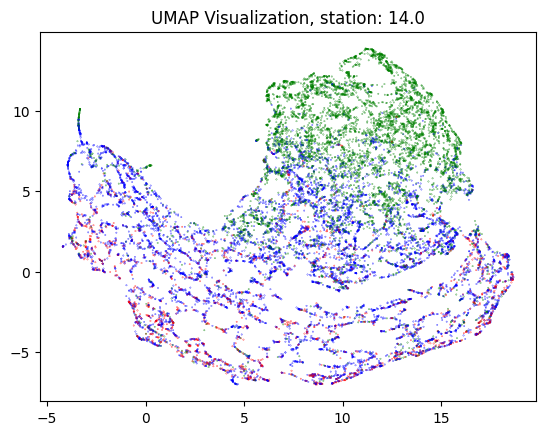

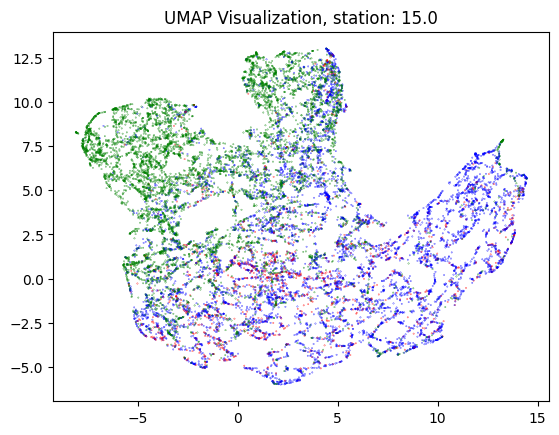

In [31]:
from sklearn.preprocessing import MinMaxScaler
for name, group in grouped:
  scaler = MinMaxScaler()
  normalized_data = scaler.fit_transform(group.drop('leaf_wetness',axis=1))

  umap_obj = umap.UMAP()
  umap_embedding = umap_obj.fit_transform(normalized_data)

  colors = ['green' if val == 0 else 'red' if val == 60 else 'blue' for val in group['leaf_wetness']]
  figure = plt.figure()
  plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], s=0.05, c=colors)
  plt.title("UMAP Visualization, station: " + str(name))
  plt.show()

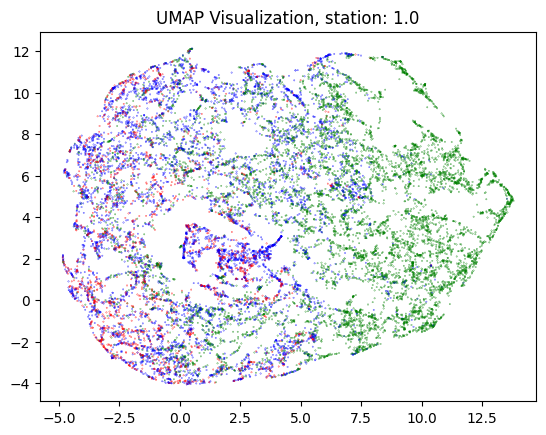

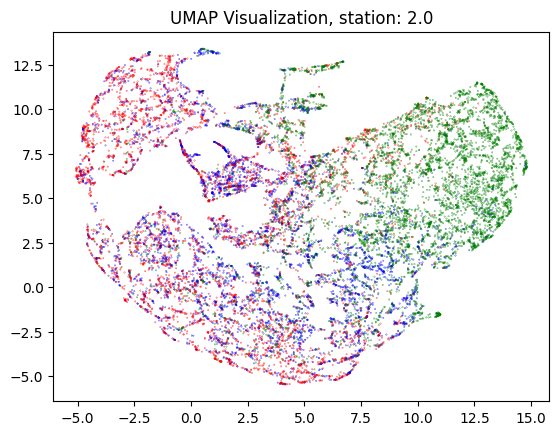

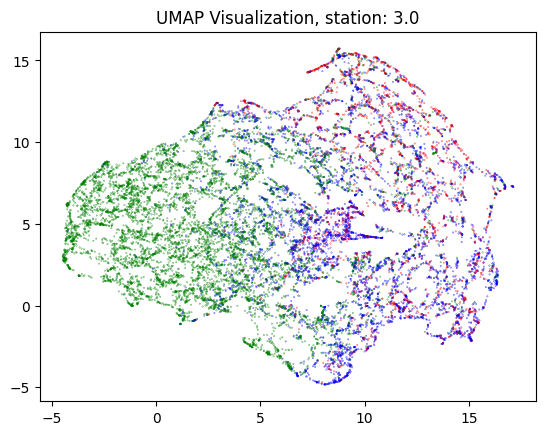

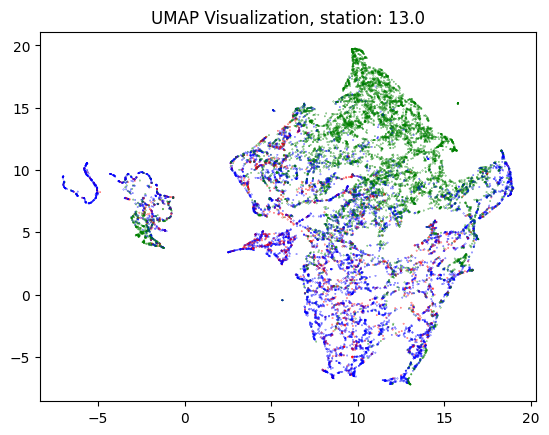

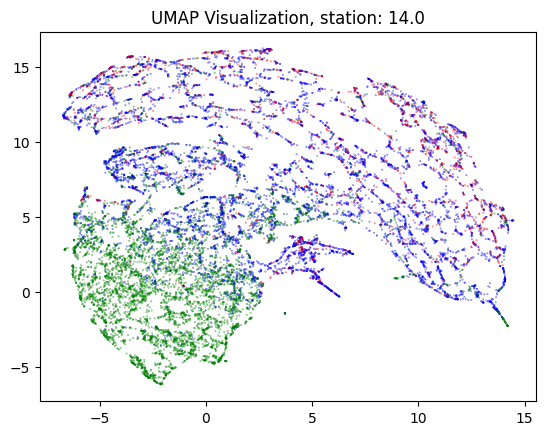

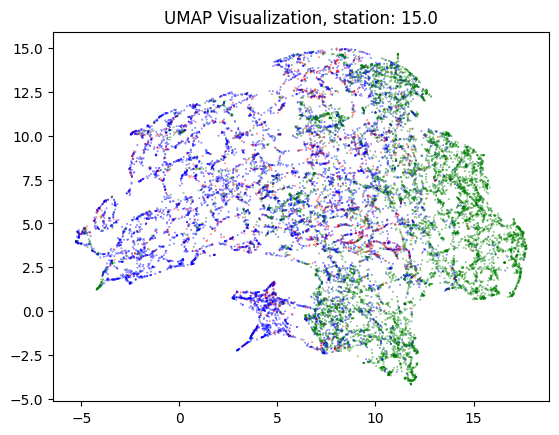

In [32]:
from sklearn.preprocessing import StandardScaler
for name, group in grouped:
  scaler = StandardScaler()
  normalized_data = scaler.fit_transform(group.drop('leaf_wetness',axis=1))

  umap_obj = umap.UMAP()
  umap_embedding = umap_obj.fit_transform(normalized_data)

  colors = ['green' if val == 0 else 'red' if val == 60 else 'blue' for val in group['leaf_wetness']]
  figure = plt.figure()
  plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], s=0.05, c=colors)
  plt.title("UMAP Visualization, station: " + str(name))
  plt.show()

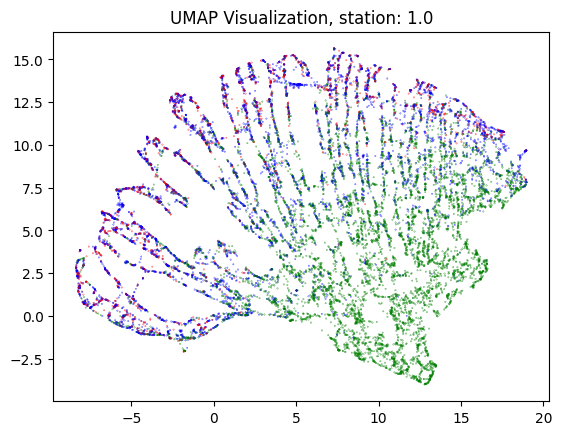

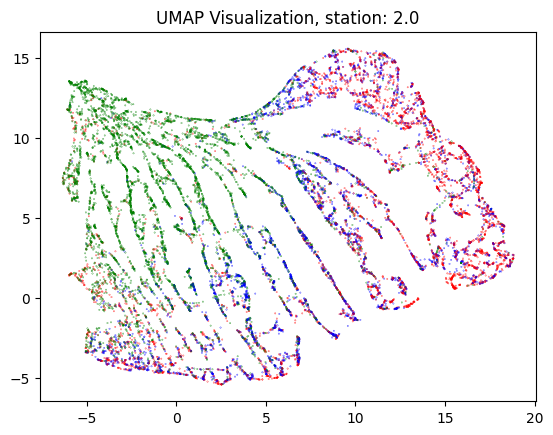

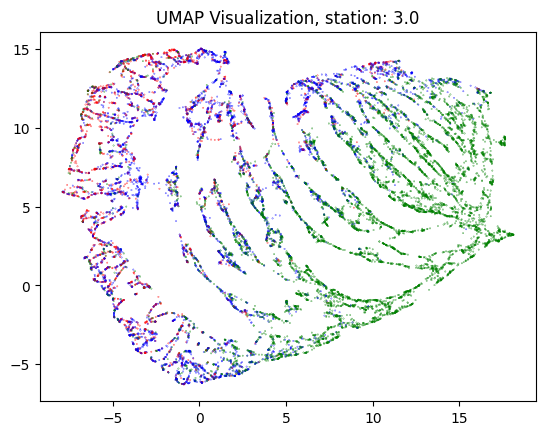

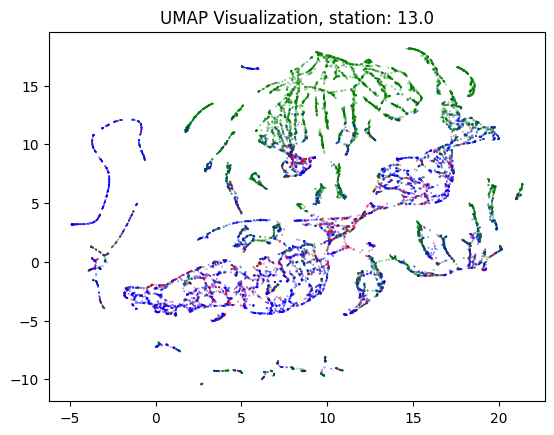

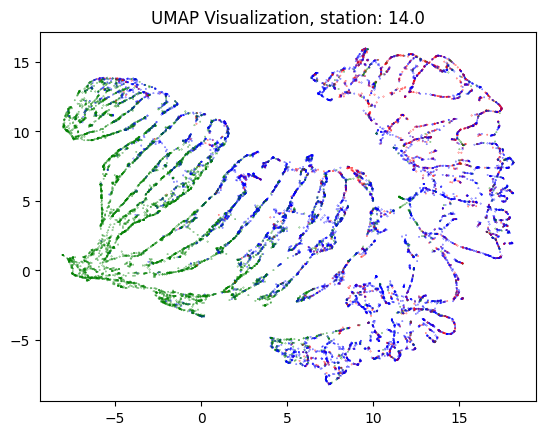

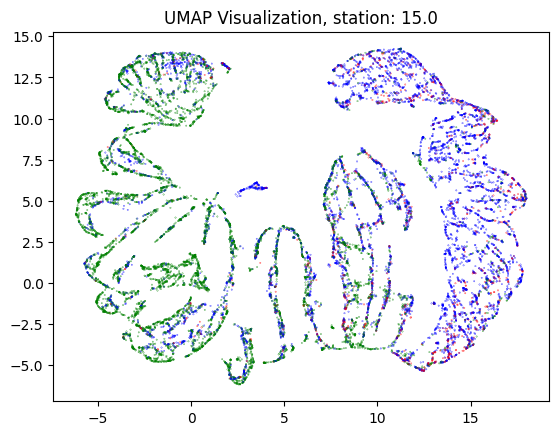

In [33]:
from sklearn.preprocessing import MaxAbsScaler
for name, group in grouped:
  scaler = MaxAbsScaler()
  normalized_data = scaler.fit_transform(group.drop('leaf_wetness',axis=1))

  umap_obj = umap.UMAP()
  umap_embedding = umap_obj.fit_transform(normalized_data)

  colors = ['green' if val == 0 else 'red' if val == 60 else 'blue' for val in group['leaf_wetness']]
  figure = plt.figure()
  plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], s=0.05, c=colors)
  plt.title("UMAP Visualization, station: " + str(name))
  plt.show()

In [34]:
# Put leaf_wetness on the first place
column_to_move = df['leaf_wetness']
df = df.drop(columns='leaf_wetness')
df.insert(0, 'leaf_wetness', column_to_move)

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [36]:
# Simple Linear Regression without previous classification
def build_regression(df):
  grouped = df.groupby('datasource_id')
  for name, group in grouped:

    scaler = MinMaxScaler()
    data_norm = scaler.fit_transform(group)

    X_train, X_test, y_train, y_test = train_test_split(data_norm[:, 1:], data_norm[:, 0], test_size=0.2, random_state=42)

    regression_model = LinearRegression()
    regression_model.fit(X_train, y_train)
    y_pred = regression_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    r2 = r2_score(y_test, y_pred)
    print("For station ", str(name), "r2=" + str(r2))

In [37]:
build_regression(df)

For station  1.0 r2=0.38531660049007654
For station  2.0 r2=0.37512462556751935
For station  3.0 r2=0.3993922297303685
For station  13.0 r2=0.27720679179364904
For station  14.0 r2=0.3391694379364997
For station  15.0 r2=0.24147904625504146


In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [39]:
#Decision tree to classify leaf_wetness == 0 and leaf_wetness > 0

def build_decision_tree(df):
  grouped = df.groupby('datasource_id')
  for name, group in grouped:

    X = group.drop('leaf_wetness', axis=1)
    y = group['leaf_wetness'].apply(lambda x: 1 if x > 0 else 0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and fit the decision tree classifier
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    # Calculate accuracy
    report = classification_report(y_test, y_pred)
    print(f"Station {name}:", report)

In [40]:
build_decision_tree(df)

Station 1.0:               precision    recall  f1-score   support

           0       0.75      0.76      0.76      1731
           1       0.75      0.74      0.74      1654

    accuracy                           0.75      3385
   macro avg       0.75      0.75      0.75      3385
weighted avg       0.75      0.75      0.75      3385

Station 2.0:               precision    recall  f1-score   support

           0       0.71      0.73      0.72      1352
           1       0.81      0.80      0.81      1975

    accuracy                           0.77      3327
   macro avg       0.76      0.76      0.76      3327
weighted avg       0.77      0.77      0.77      3327

Station 3.0:               precision    recall  f1-score   support

           0       0.80      0.78      0.79      1775
           1       0.77      0.79      0.78      1602

    accuracy                           0.79      3377
   macro avg       0.78      0.79      0.78      3377
weighted avg       0.79      0.79  

In [41]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [45]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

# Define the input sequences and target variable
X = scaled_data[:, 1:]  # Independent variables (features)
y = scaled_data[:, 0]   # Target variable (leaf_wetness)

In [47]:
# Reshape the data to have the right dimensions for LSTM
X = X.reshape((X.shape[0], 1, X.shape[1]))  # (samples, time steps, features)

# Split data into training, validation, and testing sets
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)

# Predict leaf_wetness values
predictions = model.predict(X_test)

# Inverse transform the predictions to get them in original scale
#predictions = scaler.inverse_transform(np.hstack((X_test.reshape(X_test.shape[0], X_test.shape[2]), predictions)))

# Now 'predictions' will have the predicted leaf_wetness values in original scale.

Epoch 1/50
2215/2215 [==============================] - 21s 7ms/step - loss: 0.1090 - val_loss: 0.0952
Epoch 2/50
2215/2215 [==============================] - 13s 6ms/step - loss: 0.0941 - val_loss: 0.0976
Epoch 3/50
2215/2215 [==============================] - 15s 7ms/step - loss: 0.0911 - val_loss: 0.0938
Epoch 4/50
2215/2215 [==============================] - 14s 7ms/step - loss: 0.0903 - val_loss: 0.0894
Epoch 5/50
2215/2215 [==============================] - 14s 6ms/step - loss: 0.0897 - val_loss: 0.0957
Epoch 6/50
2215/2215 [==============================] - 14s 6ms/step - loss: 0.0894 - val_loss: 0.0896
Epoch 7/50
2215/2215 [==============================] - 13s 6ms/step - loss: 0.0890 - val_loss: 0.0877
Epoch 8/50
2215/2215 [==============================] - 15s 7ms/step - loss: 0.0892 - val_loss: 0.0926
Epoch 9/50
2215/2215 [==============================] - 14s 6ms/step - loss: 0.0889 - val_loss: 0.0821
Epoch 10/50
2215/2215 [==============================] - 14s 6ms/step - l

In [48]:
y_test

array([0.0625, 0.0625, 0.0625, ..., 0.0625, 0.0625, 0.0625])

In [50]:
predictions = model.predict(X_test)

475/475 [==============================] - 1s 3ms/step


In [51]:
predictions

array([[0.0819286 ],
       [0.08232245],
       [0.08778666],
       ...,
       [0.08564948],
       [0.08716522],
       [0.08558483]], dtype=float32)